In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

font_dirs = ["./"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set( font = "Helvetica" )

sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.5)

import pandas as pd 
import wandb
api = wandb.Api()

data_name = 'norman2019'

# Project is specified by <entity/project-name>
runs = api.runs("kexinhuang/pert_gnn_simulation_" + data_name)

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [5]:
run = 6
cpa_runs = ['CPA_' + str(i) for i in range(1, run)]
pertnet_runs = ['PertNet_API_Seed' + str(i) for i in range(1, run)]
no_perturb_runs = ['No_Perturb_' + str(i) for i in range(1, run)]
linear_runs = ['Linear_' + str(i) for i in range(1, run)]

In [6]:
res_df = runs_df[runs_df.name.isin(cpa_runs + pertnet_runs + no_perturb_runs + linear_runs)]

In [7]:
def normalize_name(x):
    if x in cpa_runs:
        return 'CPA'
    elif x in pertnet_runs:
        return 'GEARS'
    elif x in linear_runs:
        return 'Linear'
    else:
        return 'No-Perturb'

In [8]:
metrics = ['test_combo_seen2_mse_top20_de_non_dropout',
          'test_combo_seen1_mse_top20_de_non_dropout',
          'test_unseen_single_mse_top20_de_non_dropout',
          'test_combo_seen0_mse_top20_de_non_dropout'
          ]
metrics_name_map = {'test_combo_seen2_mse_top20_de_non_dropout': '2/2 Seen',
                   'test_combo_seen1_mse_top20_de_non_dropout': '1/2 Seen',
                   'test_combo_seen0_mse_top20_de_non_dropout': '0/2 Seen',
                   'test_unseen_single_mse_top20_de_non_dropout': '0/1 Seen'}
method = []
category = []
result = []
for m in metrics:
    method += [normalize_name(i) for i in res_df.name.values]
    category += [metrics_name_map[m]] * len(res_df)
    result += res_df.summary.apply(lambda x: x[m]).values.tolist()

In [9]:
out = {}
out['method'] = pd.Series(method)
out['category'] = pd.Series(category)
out['Top 20 DE MSE'] = pd.Series(result)

In [10]:
out = pd.DataFrame(out)

In [11]:
color_pal = {
'Linear': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
'CPA': (0.4, 0.7607843137254902, 0.6470588235294118),
'GEARS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
'No-Perturb': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}
pal_order = [color_pal[i] for i in pd.DataFrame(out).method.unique()]

In [12]:
import numpy as np
normalize = dict(out[out.method == 'No-Perturb'].groupby('category')['Top 20 DE MSE'].agg(np.mean))

In [13]:
norm = []
for i in out[['category', 'Top 20 DE MSE']].values:
    norm.append(i[1]/normalize[i[0]])

In [14]:
out['Normalized MSE of Top 20 DE Genes'] = norm

In [15]:
color_pal

{'Linear': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'CPA': (0.4, 0.7607843137254902, 0.6470588235294118),
 'GEARS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'No-Perturb': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}

In [25]:
d = pd.DataFrame(pd.DataFrame(out).groupby(['method', 'category'])['Normalized MSE of Top 20 DE Genes'].agg(np.mean))
d = d.reset_index()
for i in d.category.unique():
    x = d[d.category == i]['Normalized MSE of Top 20 DE Genes'].values
    print(i + ': ' + str(np.abs(x[0] - x[1])/x[0]))
    
    print(i + ': ' + str(x[0]/x[1]))

Combo Seen 0: 0.4852492339575375
Combo Seen 0: 1.9426877354418715
Combo Seen 1: 0.447830655131731
Combo Seen 1: 1.8110386049022151
Combo Seen 2: 0.44087723174022236
Combo Seen 2: 1.7885159696007649
Unseen Single: 0.26006025164774965
Unseen Single: 1.3514613888858789


In [32]:
pd.DataFrame(out)

,method,category,Top 20 DE MSE,Normalized MSE of Top 20 DE Genes
0,GEARS,2/2 Seen,0.131399,0.193514
1,GEARS,2/2 Seen,0.225381,0.331924
2,GEARS,2/2 Seen,0.074711,0.110029
3,GEARS,2/2 Seen,0.111895,0.164790
4,GEARS,2/2 Seen,0.129879,0.191275
...,...,...,...,...
75,No-Perturb,0/2 Seen,0.650836,0.921832
76,No-Perturb,0/2 Seen,0.625955,0.886590
77,No-Perturb,0/2 Seen,0.930438,1.317854
78,No-Perturb,0/2 Seen,0.801830,1.135697


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


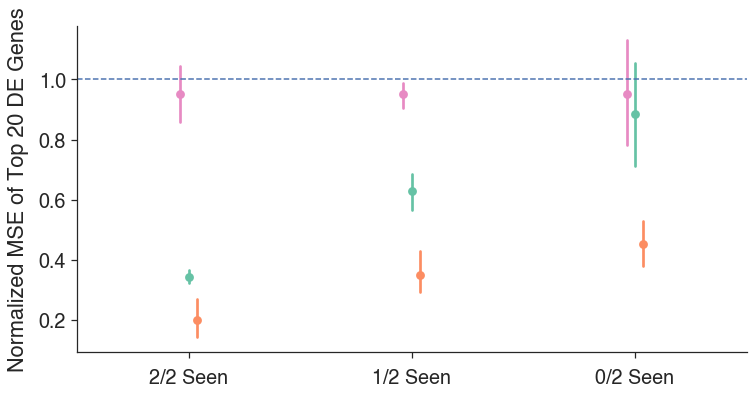

In [33]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.pointplot('category', 'Normalized MSE of Top 20 DE Genes', 
    data=pd.DataFrame(out), 
    order = ['2/2 Seen', '1/2 Seen', '0/2 Seen'], 
    hue = 'method',
    palette= [color_pal['Linear'], color_pal['CPA'], color_pal['GEARS']],         
    dodge=True, 
    join=False,
    hue_order = ['Linear', 'CPA', 'GEARS'])
sns.despine()
g.legend_.remove()
g.set(xlabel=None, )
g.axhline(1, linestyle="dashed")

plt.ylabel("Normalized MSE of Top 20 DE Genes",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)
#g.spines['left'].set_linewidth(0.8)
#g.spines['bottom'].set_linewidth(0.8)

plt.savefig('subgroup_' + data_name + '_normalized.pdf', bbox_inches='tight')
